In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from scripts.homeos import *
from scripts.plotting import *
from pathlib import Path
import  os
exp_dir = Path('experiments')
data_dir = exp_dir / 'regularization'
os.makedirs(data_dir, exist_ok=True)

plt.rcParams['xtick.labelsize'] = 14  # font size
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams["font.family"] = "serif"
mpl.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts (editable in Illustrator)
mpl.rcParams['ps.fonttype'] = 42   # Same for EPS
mpl.rcParams['svg.fonttype'] = 'none'  # Keep text as text in SVG
plt.rcParams.update({'font.size': 12, 'text.usetex': True,'text.latex.preamble': r'\usepackage{amsfonts}'})

In [79]:
rows = []
data_folders = list(data_dir.glob('*'))
for data_folder in data_folders:
    reg_value = float(data_folder.name.split('_')[-1][6:])  # adjust if format is different

    motif_folders = list(data_folder.glob('*'))
    for motif_folder in motif_folders:
        motif_name = motif_folder.name
        result_files = list(motif_folder.glob('*.npz'))
        #print("Archetype: ", motif_folder.name)
        for result_file in result_files:
            target_name = result_file.name.split('.')[0][8:]
            data = np.load(result_file)
            rows.append({
                'regularization': reg_value,
                'archetype': motif_name,
                'target': target_name,
                'train_error': data['training_loss'].item(),
                'test_error': data['test_loss'].item(),
                'jac_fro': data['jac_fro'].item(),
                'jac_spec': data['jac_spec'].item(),
                'inv_man': data['inv_man'],
            })
reg0_data_dir = exp_dir / 'all_targets' / 'motif_fits'
reg0_data_folders = list(reg0_data_dir.glob('*'))
for motif_folder in reg0_data_folders:
    motif_name = motif_folder.name
    result_files = list(motif_folder.glob('*vf*.npz'))
    for result_file in result_files:
        target_name = result_file.name.split('.')[0][8:]
        data = np.load(result_file)
        rows.append({
            'regularization': 0.0,
            'archetype': motif_name,
            'target': target_name,
            'train_error': data['training_loss'].item(),
            'test_error': data['test_loss'].item(),
            'jac_fro': data['jac_fro'].item(),
            'jac_spec': data['jac_spec'].item(),
            'inv_man': data['inv_man']
        })
df = pd.DataFrame(rows)

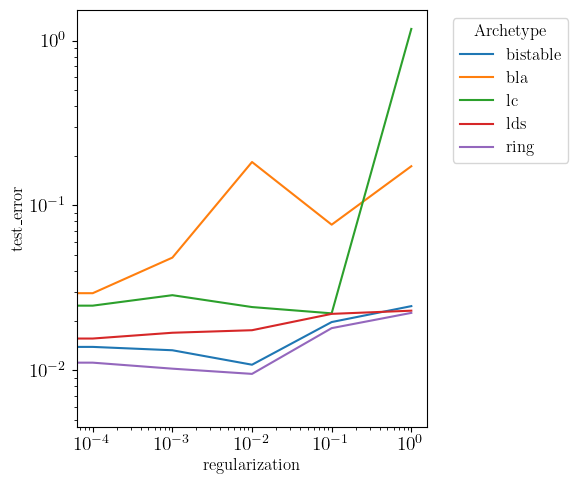

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.lineplot(data=df, x='regularization', y='test_error', hue='archetype', ax=ax)
ax.set_xlabel('regularization')
ax.set_ylabel('test_error')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(title='Archetype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

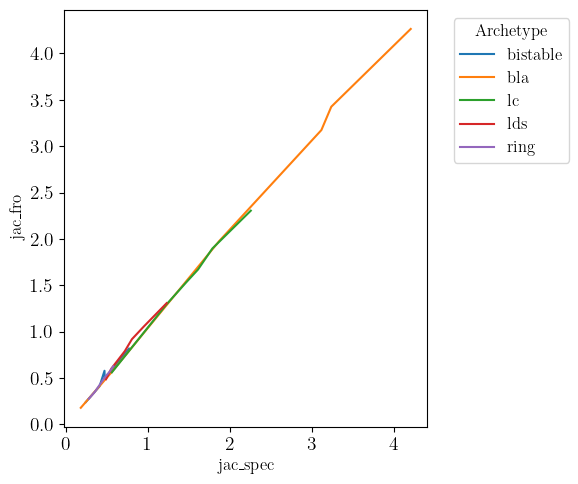

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.lineplot(data=df, x='jac_spec', y='jac_fro', hue='archetype', ax=ax)
ax.set_ylabel('jac_fro')
ax.set_xlabel('jac_spec')
ax.legend(title='Archetype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

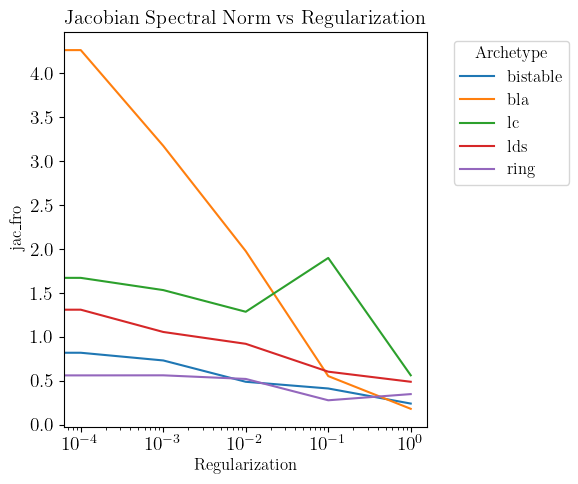

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.lineplot(data=df, x='regularization', y='jac_fro', hue='archetype', ax=ax)
ax.set_xscale('log') 
ax.set_title('Jacobian Spectral Norm vs Regularization')
ax.set_ylabel('jac_fro')
ax.set_xlabel('Regularization')
ax.legend(title='Archetype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

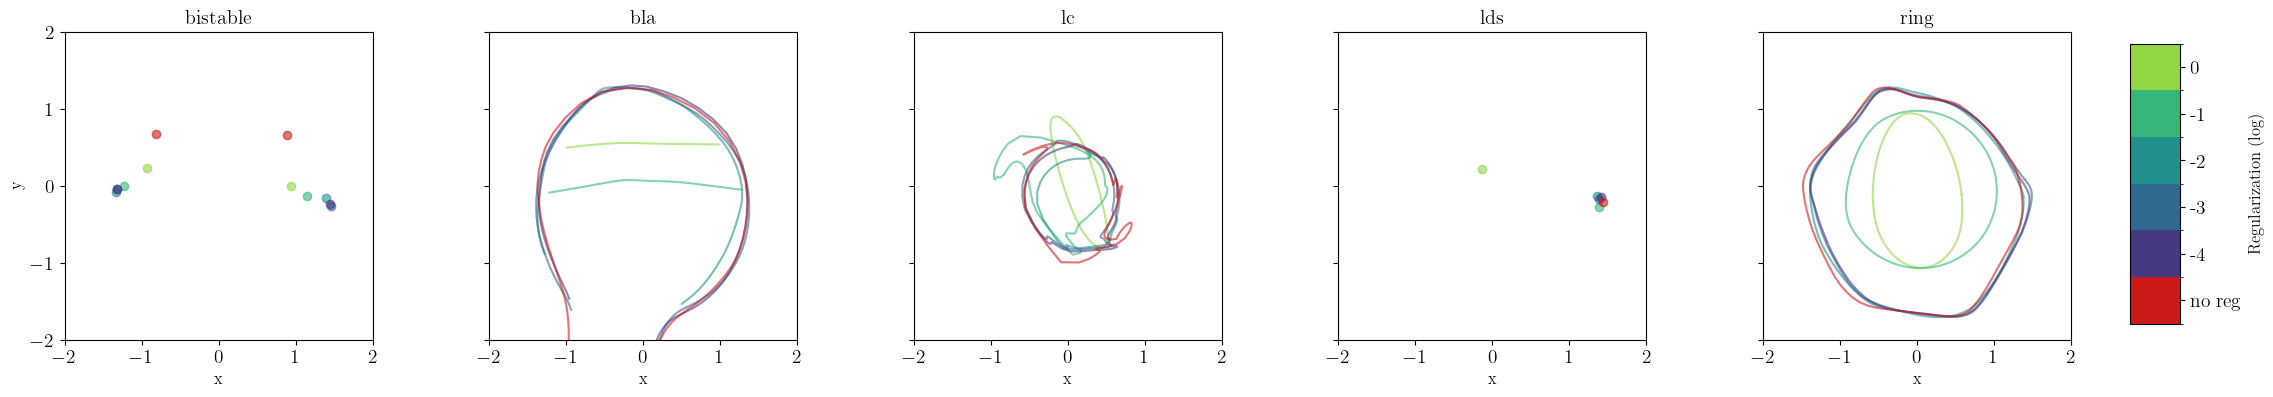

In [108]:
# Separate regularization values
unique_regs = sorted(df['regularization'].unique())
zero_reg = [reg for reg in unique_regs if reg == 0]
nonzero_regs = [reg for reg in unique_regs if reg != 0]

# Assign special color to 0, and colormap to the rest
special_color = [(0.8, 0.1, 0.1)]  # bright red for reg=0
nonzero_colors = sns.color_palette("viridis", n_colors=len(nonzero_regs))
colors = special_color + nonzero_colors

# Combine all regs for indexing
all_regs_ordered = zero_reg + nonzero_regs
reg_to_idx = {reg: i for i, reg in enumerate(all_regs_ordered)}
n_colors = len(all_regs_ordered)

# Create colormap and norm
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=range(n_colors + 1), ncolors=n_colors)

# Fixed plot limits
x_lim = y_lim = (-2., 2.)

# Prepare subplots
archetypes = df['archetype'].unique()
n = len(archetypes)
fig, axes = plt.subplots(1, n, figsize=(5 * n, 4), sharey=True)

if len(archetypes) == 1:
    axes = [axes]

for ax, archetype in zip(axes, archetypes):
    sub_df = df[df['archetype'] == archetype]

    for _, row in sub_df.iterrows():
        inv_man = row['inv_man'].reshape(-1, 2)
        reg = row['regularization']
        color = colors[reg_to_idx[reg]]

        if inv_man.shape[0] == 1 or inv_man.shape[0] == 2:
            ax.plot(inv_man[:, 0], inv_man[:, 1], 'o', color=color, alpha=0.6,
                    label=f"reg={reg:.1e}")
        else:
            ax.plot(inv_man[:, 0], inv_man[:, 1], color=color, alpha=0.6,
                    label=f"reg={reg:.1e}")

    ax.set_title(archetype)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

axes[0].set_ylabel('y')

# Colorbar
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, cax=cbar_ax)
tick_locs = np.arange(len(all_regs_ordered)) + 0.5
cbar.set_ticks(tick_locs)
cbar.set_ticklabels([f"{int(np.log10(reg))}" if reg != 0 else "no reg" for reg in all_regs_ordered])
cbar.set_label('Regularization (log)')

# Adjust layout
fig.subplots_adjust(left=0.07, right=0.88, wspace=0.3)
plt.show()